# RQ1 - Which LLM configurations are most suitable for deploying the Multiple AI-Agents layer?

In [1]:
import pandas as pd
import numpy as np
import re
import math
from pathlib import Path
from IPython.display import display

root = Path(".")

def pick_col(df, candidates):
    def norm(s): return re.sub(r'\s+', ' ', str(s).strip().lower())
    cols = [(norm(c), c) for c in df.columns]
    for pat in candidates:
        p = pat.lower()
        for lc, orig in cols:
            if p in lc:
                return orig
    return None

def choose_f1_col(df):
    cols = list(df.columns)
    cand = [c for c in cols if "f1" in c.lower()]
    prio = [c for c in cand if any(k in c.lower() for k in ["val", "valid", "test"])]
    if prio: return prio[0]
    if cand: return cand[0]
    acc = [c for c in cols if "accuracy" in c.lower()]
    acc_prio = [c for c in acc if any(k in c.lower() for k in ["val", "valid", "test"])]
    if acc_prio: return acc_prio[0]
    return acc[0] if acc else None

def to_num_series(s):
    def conv(x):
        if pd.isna(x): return np.nan
        z = str(x).strip().lower()
        z = re.sub(r'(sec\.?|s)$', '', z).strip()
        z = re.sub(r'[^\d\.\-eE]+', '', z)
        try: return float(z)
        except: return np.nan
    return s.map(conv)

def run_stats(p):
    df = pd.read_csv(p)
    f1c = choose_f1_col(df)
    rtc = pick_col(df, ["Total Time of FL Round","Total Round Time","Total FL Time","round total time"])
    agc = pick_col(df, ["Agent Time (s)","Agent Time","Agent(s) Time Overhead","Reasoning Overhead","Agent Overhead"])

    if f1c:
        if "FL Round" in df.columns:
            tmp = df.sort_values("FL Round")
            def last_valid(s):
                v = pd.to_numeric(s, errors="coerce").dropna()
                return v.iloc[-1] if len(v) else np.nan
            per_round = tmp.groupby("FL Round")[f1c].apply(last_valid).dropna()
        else:
            per_round = pd.to_numeric(df[f1c], errors="coerce").dropna()
        if len(per_round):
            f1_final = float(per_round.iloc[-1])
            f1_mean = float(per_round.mean())
            f1_max = float(per_round.max())
        else:
            f1_final = f1_mean = f1_max = np.nan
    else:
        f1_final = f1_mean = f1_max = np.nan

    ttime = to_num_series(df[rtc]).dropna().sum() if rtc else np.nan
    if agc:
        ats = to_num_series(df[agc]).dropna()
        atime = ats.iloc[-1] if len(ats) else np.nan
    else:
        atime = np.nan

    return f1_final, ttime, atime, f1_mean, f1_max

def mwu_u_from_samples(x, y):
    u = 0.0
    for xi in x:
        for yj in y:
            if xi > yj: u += 1.0
            elif xi == yj: u += 0.5
    n1, n2 = len(x), len(y)
    return u, n1*n2 - u

def mwu_exact_p_two_sided(x, y):
    x = list(map(float, x)); y = list(map(float, y))
    n1, n2 = len(x), len(y)
    if n1 == 0 or n2 == 0: return np.nan, np.nan
    U1, U2 = mwu_u_from_samples(x, y)
    U_obs = min(U1, U2)
    maxU = n1*n2
    f = [0]*(maxU+1)
    f[0] = 1
    for i in range(1, n1+1):
        g = [0]*(maxU+1)
        max_ui = i*n2
        for u in range(0, max_ui+1):
            kmax = min(u, n2)
            s = 0
            for k in range(kmax+1):
                s += f[u-k]
            g[u] = s
        f = g
    total = float(math.comb(n1+n2, n1))
    pmf_obs = f[int(U_obs)]/total
    cdf_left = sum(f[:int(U_obs)+1])/total
    p_two = 2.0*min(cdf_left, 1.0 - cdf_left + pmf_obs)
    return U_obs, min(1.0, p_two)

def holm_correction(pvals, names, alpha=0.05):
    order = np.argsort(pvals)
    m = len(pvals)
    sig = {n: False for n in names}
    prev_ok = True
    for rank, idx in enumerate(order, start=1):
        thr = alpha/(m - rank + 1)
        if pvals[idx] <= thr and prev_ok:
            sig[names[idx]] = True
            prev_ok = True
        else:
            prev_ok = False
    return sig

def order_index(name: str) -> int:
    s = name.lower()
    s = re.sub(r"[`_()\-\s]+", " ", s)

    def has(token: str) -> bool:
        return token in s

    is_multi = any(t in s for t in ["voting based", "role based", "debate based"])
    is_zero  = any(t in s for t in [" zs ", "zero shot", "zero-shot"])
    is_few   = any(t in s for t in [" fs ", "few shot", "few-shot", "fewshot"])
    is_llama = "llama" in s
    is_deep  = "deepseek" in s or "deep seek" in s
    is_gpt   = "gpt" in s

    if is_multi:
        return 200

    if "random" in s:
        return 0

    if is_zero:
        if is_llama:
            return 1
        if is_deep:
            return 2
        if is_gpt:
            return 3

    if is_few:
        if is_llama:
            return 4
        if is_deep:
            return 5
        if is_gpt:
            return 6

    return 100

def is_multi_name(name: str) -> bool:
    return bool(re.search(r"Voting-Based|Role-Based|Debate-Based", name, flags=re.IGNORECASE))

def is_fewshot_name(name: str) -> bool:
    s = name.lower()
    s = re.sub(r"[`_()\-\s]+", " ", s)
    return any(t in s for t in [" fs ", "few shot", "few-shot", "fewshot"])

def acc_array_for_config_generic(name: str, m: dict):
    if is_multi_name(name):
        return m["f1_max"]
    if is_fewshot_name(name):
        return m["acc"]
    return m["f1_mean"]

metrics = {}
for exp_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
    files = []
    for f in exp_dir.glob("*.csv"):
        if re.fullmatch(r'r?\d+\.csv', f.name):
            files.append(f)
    files = sorted(files, key=lambda x: int(re.search(r'\d+', x.stem).group())) if files else []
    if not files:
        continue
    acc, tfl, aoh = [], [], []
    mean_f1_runs, max_f1_runs = [], []
    for f in files:
        f1, tt, at, f1_mean, f1_max = run_stats(f)
        if not np.isnan(f1): acc.append(float(f1))
        if not np.isnan(tt): tfl.append(float(tt))
        if not np.isnan(at): aoh.append(float(at))
        if not np.isnan(f1_mean): mean_f1_runs.append(float(f1_mean))
        if not np.isnan(f1_max):  max_f1_runs.append(float(f1_max))
    if acc or tfl or aoh or mean_f1_runs or max_f1_runs:
        metrics[exp_dir.name] = {
            "acc": acc,
            "time": tfl,
            "over": aoh,
            "f1_mean": mean_f1_runs,
            "f1_max": max_f1_runs,
        }

configs = sorted(metrics.keys(), key=lambda k: (order_index(k), k.lower()))
baseline = next((k for k in configs if k.lower() == "random"), (configs[0] if configs else None))

def mean_std(a):
    if not a: return (np.nan, np.nan, 0)
    v = np.array(a, float)
    return float(np.mean(v)), float(np.std(v, ddof=1)) if v.size > 1 else 0.0, int(v.size)

rows = []
for c in configs:
    m = metrics[c]
    arr_acc = acc_array_for_config_generic(c, m)
    acc_m, acc_s, n_acc = mean_std(arr_acc)
    t_m, t_s, n_t = mean_std(m["time"])
    o_m, o_s, n_o = mean_std(m["over"])
    rows.append({
        "Configuration": c,
        "acc_mean": acc_m, "acc_std": acc_s,
        "time_mean": t_m, "time_std": t_s,
        "over_mean": o_m, "over_std": o_s,
        "n_runs": max(n_acc, n_t, n_o)
    })

summary = pd.DataFrame(rows)

sig_acc = {}; sig_time = {}; sig_over = {}
if baseline is not None:
    names = [c for c in configs if c != baseline]
    if names:
        def acc_array_for_config(name):
            m = metrics[name]
            return acc_array_for_config_generic(name, m)
        def p_or_nan_acc(base_name, other_name):
            base = acc_array_for_config(base_name)
            other = acc_array_for_config(other_name)
            if len(base) >= 1 and len(other) >= 1:
                _, p = mwu_exact_p_two_sided(base, other)
                return p
            return np.nan
        def p_or_nan(base, other):
            if len(base) >= 1 and len(other) >= 1:
                _, p = mwu_exact_p_two_sided(base, other)
                return p
            return np.nan
        p_acc  = [p_or_nan_acc(baseline, c) for c in names]
        p_time = [p_or_nan(metrics[baseline]["time"], metrics[c]["time"]) for c in names]
        p_over = [p_or_nan(metrics[baseline]["over"], metrics[c]["over"]) for c in names]
        p_acc  = np.array([1.0 if np.isnan(x) else x for x in p_acc])
        p_time = np.array([1.0 if np.isnan(x) else x for x in p_time])
        p_over = np.array([1.0 if np.isnan(x) else x for x in p_over])
        sig_acc  = holm_correction(p_acc,  np.array(names), alpha=0.05)
        sig_time = holm_correction(p_time, np.array(names), alpha=0.05)
        sig_over = holm_correction(p_over, np.array(names), alpha=0.05)

def fmt_acc(m, s, mark):
    if np.isnan(m): return ""
    t = f"{m:.2f} ± {s:.2f}"
    return t + ("*" if mark else "")

def fmt_sec(m, s, mark):
    if np.isnan(m): return ""
    t = f"{int(round(m))} ± {int(round(s))} s"
    return t + ("*" if mark else "")

disp = pd.DataFrame({
    "Configuration": summary["Configuration"],
    "Model Accuracy (mean ± std)": [
        fmt_acc(r.acc_mean, r.acc_std, bool(sig_acc.get(r.Configuration, False)))
        for r in summary.itertuples()
    ],
    "Total FL Time (mean ± std)": [
        fmt_sec(r.time_mean, r.time_std, bool(sig_time.get(r.Configuration, False)))
        for r in summary.itertuples()
    ],
    "Agent Overhead (mean ± std)": [
        fmt_sec(r.over_mean, r.over_std, bool(sig_over.get(r.Configuration, False)))
        for r in summary.itertuples()
    ],
    "n_runs": summary["n_runs"]
})

multi_mask = disp["Configuration"].str.contains(
    r"Voting-Based|Role-Based|Debate-Based",
    case=False,
    regex=True
)

if multi_mask.any() and (~multi_mask).any():
    single = disp[~multi_mask].copy()
    delim_single = pd.DataFrame({
        "Configuration": ["Single AI-Agents"],
        "Model Accuracy (mean ± std)": [""],
        "Total FL Time (mean ± std)": [""],
        "Agent Overhead (mean ± std)": [""],
        "n_runs": [""]
    })
    disp_grouped = pd.concat(
        [delim_single, single],  
        ignore_index=True
    )
else:
    disp_grouped = disp

styler = disp_grouped.style
if hasattr(styler, "hide"):
    styler = styler.hide(axis="index")
elif hasattr(styler, "hide_index"):
    styler = styler.hide_index()

display(styler)
Path("LLM_summary_stats.csv").write_text(disp_grouped.to_csv(index=False), encoding="utf-8")

Configuration,Model Accuracy (mean ± std),Total FL Time (mean ± std),Agent Overhead (mean ± std),n_runs
Single AI-Agents,,,,
random,0.74 ± 0.01,3796 ± 977 s,0 ± 0 s,10
zero-shot llama,0.77 ± 0.01*,1422 ± 66 s*,7 ± 0 s*,10
zero-shot deepseek,0.80 ± 0.00*,1870 ± 240 s*,19 ± 4 s*,10
zero-shot gpt,0.79 ± 0.01*,2276 ± 665 s,176 ± 6 s*,10
few-shot llama,0.82 ± 0.02*,1372 ± 151 s*,5 ± 1 s*,10
few-shot deepseek,0.84 ± 0.01*,1893 ± 188 s*,18 ± 1 s*,10
few-shot gpt,0.83 ± 0.01*,1765 ± 627 s*,180 ± 0 s*,10


501

# Pattern activation frequency

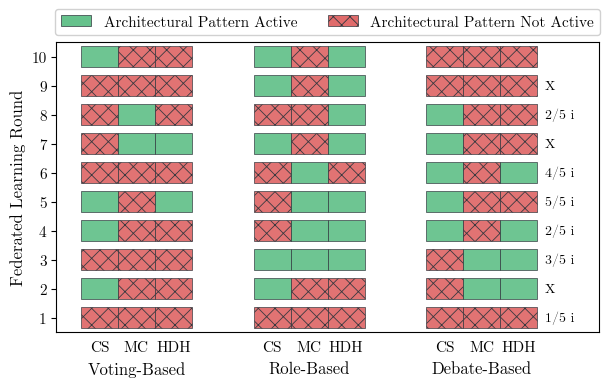

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatches
from pathlib import Path
import re

RUN_IDS = {
    "Voting-Based": 10,
    "Role-Based": 2,
    "Debate-Based": 8,
}

COLOR_ON = "#66C28C"
COLOR_OFF = "#E06B6B"
EDGE_COLOR = "#30363d"
EDGE_LW = 0.5
ALPHA_BAR = 0.95

plt.rcParams["font.family"] = "CMU Serif"
plt.rcParams["hatch.color"] = "#777777"
plt.rcParams["hatch.linewidth"] = 0.6
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["legend.fontsize"] = 11
FIGSIZE = (7, 5)

LEGEND_HANDLES = [
    mpatches.Patch(
        facecolor=COLOR_ON,
        edgecolor=EDGE_COLOR,
        linewidth=EDGE_LW,
        label="Architectural Pattern Active",
    ),
    mpatches.Patch(
        facecolor=COLOR_OFF,
        edgecolor=EDGE_COLOR,
        linewidth=EDGE_LW,
        hatch="xx",
        label="Architectural Pattern Not Active",
    ),
]

FORCE_ROUNDS = 10
ROUNDS = int(FORCE_ROUNDS)
approaches_rows = ["Voting-Based", "Role-Based", "Debate-Based"]
patterns = ["CS", "MC", "HDH"]
X_COL_W = 0.03
X_GAP = 0.00
GROUP_GAP_X = 0.05
ROW_GAP = -0.13
rect_h_v = 0.6 - ROW_GAP
y_centers = np.arange(1, ROUNDS + 1)
PAT_FS = plt.rcParams["xtick.labelsize"]
APPR_FS = plt.rcParams["axes.labelsize"]


def parse_ap_list(val):
    if pd.isna(val):
        return None
    if isinstance(val, (list, tuple, np.ndarray)):
        tokens = [str(x).strip().upper() for x in val]
    else:
        txt = str(val).upper()
        tokens = re.findall(r"\bON\b|\bOFF\b", txt)
    if not tokens:
        return None
    if len(tokens) < 6:
        tokens = tokens + ["OFF"] * (6 - len(tokens))
    return tokens[:6]


def build_states_from_folders(rounds, run_ids):
    states = {}
    for appr in approaches_rows:
        if appr not in run_ids:
            raise ValueError(f"No run id specified for approach '{appr}'")
        run_id = run_ids[appr]

        states[appr] = {"CS": [], "MC": [], "HDH": []}
        csv_path = Path(appr) / f"r{run_id}.csv"
        if not csv_path.exists():
            raise FileNotFoundError(f"File '{csv_path}' not found")

        df = pd.read_csv(csv_path)

        round_col = None
        for c in df.columns:
            if "fl round" in c.lower():
                round_col = c
                break
        if round_col is None:
            raise ValueError(f"No 'FL Round' column in {csv_path}")

        ap_col = None
        for c in df.columns:
            if "ap list" in c.lower():
                ap_col = c
                break
        if ap_col is None:
            raise ValueError(f"No 'AP List' column in {csv_path}")

        for r in range(1, rounds + 1):
            sub = df[df[round_col] == r]
            if sub.empty:
                tokens = None
            else:
                series = sub[ap_col].dropna()
                if len(series) == 0:
                    tokens = None
                else:
                    tokens = parse_ap_list(series.iloc[-1])

            if tokens is None:
                cs = mc = hdh = 0
            else:
                cs = 1 if tokens[0] == "ON" else 0
                mc = 1 if tokens[2] == "ON" else 0
                hdh = 1 if tokens[5] == "ON" else 0

            states[appr]["CS"].append(cs)
            states[appr]["MC"].append(mc)
            states[appr]["HDH"].append(hdh)

    return states


states = build_states_from_folders(ROUNDS, RUN_IDS)

fig2, ax2 = plt.subplots(figsize=FIGSIZE)
ax2.set_yticks(y_centers)
ax2.set_yticklabels([str(i) for i in y_centers])
ax2.set_ylabel("Federated Learning Round")

x_lefts = {}
for g_idx, appr in enumerate(approaches_rows):
    x_base = g_idx * (3 * (X_COL_W + X_GAP) + GROUP_GAP_X)
    for i, pat in enumerate(patterns):
        x_lefts[(appr, pat)] = x_base + i * (X_COL_W + X_GAP)

all_lefts = [x_lefts[(a, p)] for a in approaches_rows for p in patterns]
x_min = min(all_lefts) - 0.02
x_max = max(all_lefts) + X_COL_W + 0.02
ax2.set_xlim(x_min, x_max + 0.03)
ax2.set_ylim(0.5, ROUNDS + 0.5)

for appr in approaches_rows:
    for pat in patterns:
        x_left = x_lefts[(appr, pat)]
        for r, yc in enumerate(y_centers):
            is_on = bool(states[appr][pat][r])
            ax2.barh(
                y=yc,
                width=X_COL_W,
                left=x_left,
                height=rect_h_v,
                color=COLOR_ON if is_on else COLOR_OFF,
                edgecolor=EDGE_COLOR,
                linewidth=EDGE_LW,
                hatch=None if is_on else "xx",
                alpha=ALPHA_BAR,
                align="center",
                zorder=3,
            )

trans = mtransforms.blended_transform_factory(ax2.transData, ax2.transAxes)
for appr in approaches_rows:
    for pat in patterns:
        x_center = x_lefts[(appr, pat)] + X_COL_W / 2.0
        ax2.text(
            x_center,
            -0.03,
            pat,
            transform=trans,
            ha="center",
            va="top",
            fontsize=PAT_FS,
            clip_on=False,
        )

for g_idx, appr in enumerate(approaches_rows):
    x_base = g_idx * (3 * (X_COL_W + X_GAP) + GROUP_GAP_X)
    x_groupc = x_base + (X_COL_W + X_GAP) * 1 + X_COL_W / 2.0
    ax2.text(
        x_groupc,
        -0.10,
        appr,
        transform=trans,
        ha="center",
        va="top",
        fontsize=APPR_FS,
        clip_on=False,
    )

ax2.grid(False)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.tick_params(axis="x", length=0)
ax2.legend(
    handles=LEGEND_HANDLES,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.14),
    ncol=2,
    frameon=True,
    framealpha=0.9,
)
plt.subplots_adjust(bottom=0.30)

DEB_HDH_NOTES = [1, "X", 3, 2, 5, 4,"X", 2, "X"]
x_text = x_lefts[("Debate-Based", "HDH")] + X_COL_W + 0.006
for yc, note in zip(y_centers, (DEB_HDH_NOTES + [None] * ROUNDS)[:ROUNDS]):
    if note is None:
        continue
    s = str(note).strip()
    if s.upper() == "X":
        txt = "X"
    else:
        try:
            v = int(float(s))
        except Exception:
            continue
        if not (1 <= v <= 5):
            continue
        txt = f"{v}/5 i"
    ax2.text(
        x_text,
        yc,
        txt,
        ha="left",
        va="center",
        fontsize=10,
        fontfamily="CMU Serif",
        fontstyle="italic",
        clip_on=True,
        zorder=6,
    )

plt.savefig("patternActivationVert.pdf", bbox_inches="tight", dpi=600, facecolor="white")
plt.show()

# RQ 2 - How effective is the Multiple AI-Agents layer in improving FL system evaluation metrics?

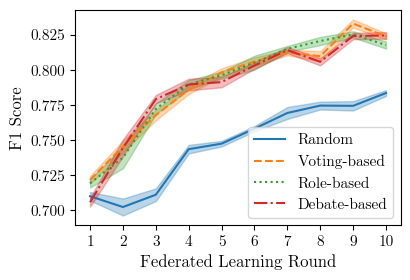

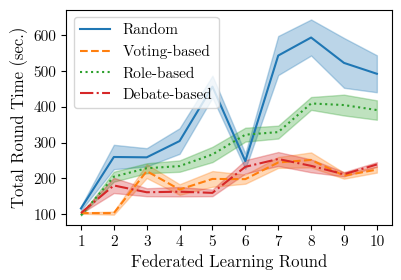

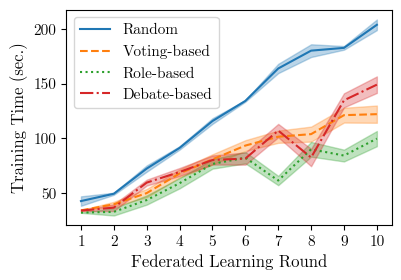

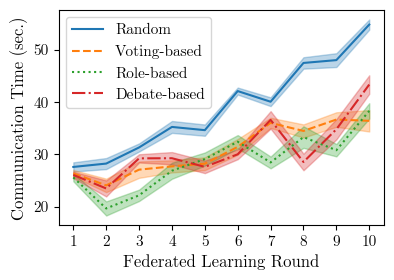

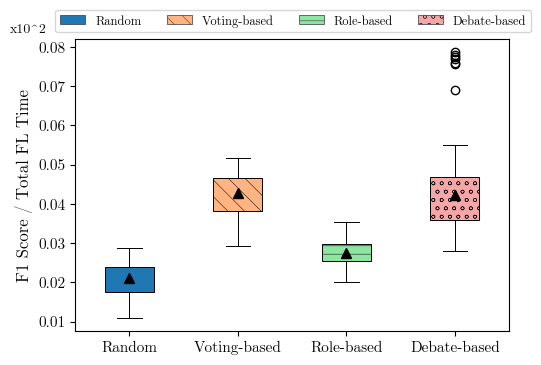

In [10]:
import os,glob
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches

SAVEPATH="./";os.makedirs(SAVEPATH,exist_ok=True)
BASE_DIR="."
plt.rcParams["font.family"]="CMU Serif"
plt.rcParams["axes.labelsize"]=12
plt.rcParams["xtick.labelsize"]=11
plt.rcParams["ytick.labelsize"]=11
plt.rcParams["legend.fontsize"]=11

folders={
    "random":"Random",
    "voting-based":"Voting-based",
    "role-based":"Role-based",
    "debate-based":"Debate-based",
}
order=list(folders.values())
mark={"Random":"o","Voting-based":"s","Role-based":"^","Debate-based":"D"}
ls={"Random":"-","Voting-based":"--","Role-based":":","Debate-based":"-."}
PALETTE=["#1f77b4","#ff7f0e","#2ca02c","#d62728"]
COLORS={name:PALETTE[i] for i,name in enumerate(order)}
AGENT_COLORS={
    "Voting-based":"#FFB482",
    "Role-based":"#8DE5A1",
    "Debate-based":"#F6A6A6",
}
HATCHES={
    "Random":"",
    "Voting-based":"\\\\",
    "Role-based":"--",
    "Debate-based":"oo",
}
EDGE_COLOR="#30363d"

files=sum([glob.glob(os.path.join(BASE_DIR,k,"*.csv")) for k in folders],[])

def read_norm(p):
    df=pd.read_csv(p)
    time_candidates=["Total Round Time","Total Time of FL Round","Total Time"]
    time_col=None
    for c in time_candidates:
        if c in df.columns:
            time_col=c;break
    if time_col is None:
        raise ValueError(f"No total-round-time column found in {p}")
    rename_map={
        "FL Round":"round",
        "Client ID":"client",
        "Val F1":"F1",
        time_col:"total_time",
        "Training Time":"training_time",
        "Communication Time":"communication_time",
    }
    df=df.rename(columns=rename_map)
    for c in ["round","F1","total_time","training_time","communication_time"]:
        df[c]=pd.to_numeric(
            df[c].astype(str)
                .str.replace("\u202f","")
                .str.replace(" ","")
                .str.replace(",",".",regex=False),
            errors="coerce",
        )
    df["round"]=df["round"].astype(int)
    df["approach"]=folders[os.path.basename(os.path.dirname(p))]
    df["run"]=os.path.splitext(os.path.basename(p))[0]
    return df[["approach","run","round","F1","total_time","training_time","communication_time"]]

DF=pd.concat([read_norm(p) for p in files],ignore_index=True)
G=DF.groupby(["approach","run","round"],as_index=False).mean(numeric_only=True)

A=G.groupby(["approach","round"]).agg(
    {
        "F1":["mean","std","count"],
        "total_time":["mean","std","count"],
        "training_time":["mean","std","count"],
        "communication_time":["mean","std","count"],
    }
)
present=list(pd.Index(order).intersection(A.index.get_level_values("approach").unique()))
xt=sorted(A.index.get_level_values("round").unique())

def kfmt(x,pos):
    if x==0:return "0"
    if abs(x)>=1000:
        v=x/1000.0
        return f"{v:.1f}k" if (v%1) else f"{int(v)}k"
    return f"{int(x)}"

FIGSIZE=(4.2,2.8)
BOX_FIGSIZE=(5.6,3.8)
plt.rcParams["figure.figsize"]=FIGSIZE

def draw(metric,ylabel,grid_axis,yfmt=False,fname=None):
    fig,ax=plt.subplots(figsize=FIGSIZE)
    for a in present:
        stat=A.loc[a,metric]
        m=stat["mean"]
        s=stat["std"].fillna(0)
        n=stat["count"].clip(lower=1)
        ci=0.5*s/np.sqrt(n)
        lo=m-ci
        hi=m+ci
        if metric=="F1" and a=="Random" and 1 in m.index:
            d=0.71-m.loc[1]
            m.loc[1]=0.71
            lo.loc[1]+=d
            hi.loc[1]+=d
        if metric=="F1":
            lo=lo.clip(0,1);hi=hi.clip(0,1)
        color=COLORS.get(a)
        ax.plot(m.index,m.values,linestyle=ls[a],label=a,color=color)
        ax.fill_between(m.index,lo.values,hi.values,alpha=0.3,color=color)
    ax.set_xlabel("Federated Learning Round")
    ax.set_ylabel(ylabel)
    ax.set_xticks(xt)
    if yfmt:ax.yaxis.set_major_formatter(FuncFormatter(kfmt))
    ax.legend()
    fig.savefig(os.path.join(SAVEPATH,fname or f"{metric}.pdf"),bbox_inches="tight")
    plt.show()

def _draw_score_boxplot(df_source,value_col,ylabel,fname):
    fig,ax=plt.subplots(figsize=BOX_FIGSIZE)
    data=[];labels=[]
    for a in order:
        sub=df_source.loc[df_source["approach"]==a,value_col].dropna()
        if sub.empty:continue
        data.append(sub.values);labels.append(a)
    if not data:return
    bp=ax.boxplot(data,tick_labels=labels,patch_artist=True)
    for box,label in zip(bp["boxes"],labels):
        face=AGENT_COLORS.get(label,COLORS.get(label,"#cccccc"))
        box.set_facecolor(face)
        box.set_edgecolor("black")
        box.set_linewidth(0.7)
        box.set_hatch(HATCHES.get(label,""))
    for w in bp["whiskers"]:
        w.set_color("black");w.set_linewidth(0.7)
    for median in bp["medians"]:
        xdata=median.get_xdata();ydata=median.get_ydata()
        xmid=float(np.mean(xdata));ymid=float(np.mean(ydata))
        median.set_alpha(0.0)
        ax.plot(xmid,ymid,marker="^",markersize=7,color="black",zorder=7)
    for cap in bp["caps"]:
        cap.set_color("black");cap.set_linewidth(0.7)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos:f"{x*1e2:.2f}"))
    ax.text(-0.15,1.01,"x10^2",transform=ax.transAxes,ha="left",va="bottom",fontfamily="CMU Serif",fontsize=10)
    ax.set_ylabel(ylabel)
    handles=[];labels_leg=[]
    for name in order:
        if name not in labels:continue
        face=AGENT_COLORS.get(name,COLORS.get(name,"#cccccc"))
        hatch=HATCHES.get(name,"")
        patch=mpatches.Patch(facecolor=face,edgecolor=EDGE_COLOR,linewidth=0.5,hatch=hatch)
        handles.append(patch);labels_leg.append(name)
    ax.legend(handles,labels_leg,bbox_to_anchor=(-0.06,1.12),fontsize=9,ncol=len(handles),frameon=True)
    fig.savefig(os.path.join(SAVEPATH,fname),bbox_inches="tight")
    plt.show()

G_sim=G.copy()
G_sim["total_sim_time"]=G_sim.groupby(["approach","run"])["total_time"].transform("sum")
G_sim["score_sim"]=G_sim["F1"]/G_sim["total_sim_time"].replace(0,np.nan)

def draw_score_sim_boxplot_approach(fname="ScoreSim_Boxplot.pdf"):
    _draw_score_boxplot(df_source=G_sim,value_col="score_sim",ylabel="F1 Score / Total FL Time",fname=fname)

draw("F1","F1 Score","y",False,"F1.pdf")
draw("total_time","Total Round Time (sec.)","x",True,"TotalTime.pdf")
draw("training_time","Training Time (sec.)","x",True,"TrainingTime.pdf")
draw("communication_time","Communication Time (sec.)","x",True,"CommTime.pdf")
draw_score_sim_boxplot_approach()

# RQ3 - What is the computational overhead introduced by the Multiple AI-Agents layer?

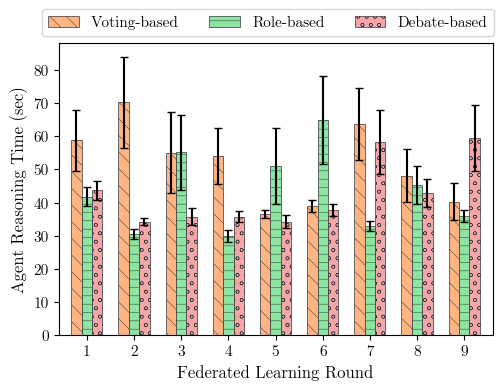

=== Agent reasoning time summary (rounds 1–9) ===
Voting-based: per-round mean = 51.75 s, total over rounds 1–9 = 465.72 s
Role-based: per-round mean = 43.07 s, total over rounds 1–9 = 387.64 s
Debate-based: per-round mean = 42.47 s, total over rounds 1–9 = 382.25 s


In [7]:
import os,glob,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams.update({'font.family':'CMU Serif','axes.labelsize':12,'xtick.labelsize':11,'ytick.labelsize':11,'legend.fontsize':11,'axes.labelweight':'bold','hatch.color':'#777777','hatch.linewidth':0.35})

FIGSIZE=(5.6,3.8);EDGE_COLOR="#30363d";EDGE_LW=0.5
order=["Voting-based","Role-based","Debate-based"]
PALETTE=["#FFB482","#8DE5A1","#F6A6A6"];COLORS=dict(zip(order,PALETTE))
HATCHES={"Voting-based":"\\\\","Role-based":"--","Debate-based":"oo"}
dirs={"Voting-based":"voting-based","Role-based":"role-based","Debate-based":"debate-based"}
NUM_RE=re.compile(r'[-+]?\d+(?:[.,]\d+)?')

def _read_csv_any(path):
    if not path:return None
    for sep in [None,",",";","\t","|"]:
        try:
            df=pd.read_csv(path,sep=sep,engine="python")
            if df is not None and not df.empty:return df
        except:pass
    return None

def _coerce_number(x):
    m=NUM_RE.search(str(x))
    if not m:return np.nan
    try:return float(m.group(0).replace(',','.'))
    except:return np.nan

def _find_agent_time_col(df):
    cand=[c for c in df.columns if re.search(r'\bagent\b',str(c),re.I) and re.search(r'\btime\b',str(c),re.I)]
    if cand:return cand[-1]
    for c in reversed(df.columns):
        s=df[c].map(_coerce_number)
        if s.notna().mean()>0.2:return c
    return df.columns[-1]

def _agent_time_from_csv(path,rounds=10):
    df=_read_csv_any(path)
    if df is None or df.empty:return np.full(rounds,np.nan,float)
    col_time=_find_agent_time_col(df)
    ser_time=df[col_time].map(_coerce_number)
    col_round=next((c for c in df.columns if re.search(r'\bround\b',str(c),re.I)),None)
    if col_round is not None:
        ser_round=pd.to_numeric(df[col_round],errors='coerce').astype('Int64')
        tmp=pd.DataFrame({'r':ser_round,'t':ser_time}).dropna(subset=['r'])
        if tmp.empty:
            arr=ser_time.to_numpy(dtype=float)[:rounds]
            if arr.size<rounds:arr=np.pad(arr,(0,rounds-arr.size),constant_values=np.nan)
            return arr
        agg=tmp.groupby('r')['t'].apply(lambda s:s.dropna().iloc[-1] if s.dropna().size else np.nan)
        out=np.full(rounds,np.nan,float)
        for r in range(1,rounds+1):
            v=agg.get(r,np.nan)
            out[r-1]=np.nan if pd.isna(v) else float(v)
        return out
    arr=ser_time.to_numpy(dtype=float)[:rounds]
    if arr.size<rounds:arr=np.pad(arr,(0,rounds-arr.size),constant_values=np.nan)
    return arr

def _agent_time_stats_from_dir(dirpath,rounds=10,use_sem=True):
    if not dirpath or not os.path.isdir(dirpath):return np.zeros(rounds,float),np.zeros(rounds,float)
    files=glob.glob(os.path.join(dirpath,"**","*.csv"),recursive=True)
    if not files:return np.zeros(rounds,float),np.zeros(rounds,float)
    arrs=[_agent_time_from_csv(p,rounds) for p in files]
    stacked=np.vstack(arrs)
    mean=np.nanmean(stacked,axis=0)
    if stacked.shape[0]>1:
        std=np.nanstd(stacked,axis=0,ddof=1)
        err=std/np.sqrt(stacked.shape[0]) if use_sem else std
    else:
        err=np.zeros(rounds,float)
    ERR_SCALE=0.7
    err=err*ERR_SCALE
    mean=np.nan_to_num(mean,nan=0.0);err=np.nan_to_num(err,nan=0.0)
    return mean,err

def _pick_csv(dirpath):
    if not dirpath or not os.path.isdir(dirpath):return None
    files=glob.glob(os.path.join(dirpath,"**","*.csv"),recursive=True)
    if not files:return None
    files.sort(key=lambda p:os.path.getmtime(p),reverse=True)
    return files[0]

RAW_ROUNDS=10;ROUNDS=9
labels=np.arange(1,10)
means={};errs={}
for a in order:
    m_full,e_full=_agent_time_stats_from_dir(dirs.get(a),RAW_ROUNDS)
    means[a]=m_full[:ROUNDS]
    errs[a]=e_full[:ROUNDS]

fig,ax=plt.subplots(figsize=FIGSIZE)
width=0.22;offsets=np.linspace(-width,width,len(order));bars_pos={}
for i,a in enumerate(order):
    x=labels+offsets[i]
    b=ax.bar(x,means[a],width=width,yerr=errs[a],capsize=3,color=COLORS[a],hatch=HATCHES[a],alpha=1.0,edgecolor=EDGE_COLOR,linewidth=EDGE_LW,label=a,zorder=2)
    bars_pos[a]=(x,b)

ax.set_xlabel("Federated Learning Round");ax.set_ylabel("Agent Reasoning Time (sec)")
ax.set_xticks(labels);ax.set_xlim(0.4,9.6)
handles=[mpatches.Patch(facecolor=COLORS[a],edgecolor=EDGE_COLOR,linewidth=0.5,hatch=HATCHES[a]) for a in order]
ax.legend(handles,order,bbox_to_anchor=(1.02,1.14),ncol=3,frameon=True)
plt.savefig("agent_overhead.pdf",bbox_inches="tight",dpi=600);plt.show()

print("=== Agent reasoning time summary (rounds 1–9) ===")
for a in order:
    m=means[a]
    per_round_mean=float(np.mean(m))
    total_over_rounds=float(np.sum(m))
    print(f"{a}: per-round mean = {per_round_mean:.2f} s, total over rounds 1–9 = {total_over_rounds:.2f} s")